In [1]:
# Usual imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (18, 10)

# OpenCV
import cv2

# Keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

# Other modules
from pathlib import Path
from glob import glob

import tensorflow as tf

# CleverHans stuff
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.basic_iterative_method import basic_iterative_method
from cleverhans.tf2.attacks.carlini_wagner_l2 import carlini_wagner_l2

Similar to what we did in Project 1, we will now define some constant for the path to annotations and images

In [2]:
DATA_FOLDER = Path('../data')
IMG_FOLDER = Path(DATA_FOLDER / 'tsrd-train')
ANNOTATIONS = Path(DATA_FOLDER / 'TsignRecgTrain4170Annotation.txt')
COL_NAMES = ['filename','width','height','x1','y1','x2','y2','label']
MODEL_FOLDER = Path('../Part_1')
MODEL = Path(MODEL_FOLDER / 'chinese_traffic_sign_classifier_v1.h5')

In [3]:
df = pd.read_csv(ANNOTATIONS, names=COL_NAMES, sep=';', header=None, index_col=False)
old_classifier = load_model(MODEL)

In [4]:
classifier = tf.keras.Model(old_classifier.input, old_classifier.layers[-1].output)
print(old_classifier.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 130, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 26, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 22, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

Let's verify that it's exactly the same model.

In [5]:
print(classifier.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 128, 134, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 124, 130, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 26, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 22, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832 

In order to create the adversarial examples, we will first import all the images. We use the same function calls from Project 1:

In [6]:
images = glob(str(IMG_FOLDER) + '/*.png')
IMG_SIZE = (134,128)

dataset = []
labels = []

for idx in range(len(images)):
    full_img_path = images[idx]
    filename = Path(full_img_path).name
    img_bgr = cv2.imread(full_img_path)
    image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMG_SIZE)
    image = img_to_array(image)
    dataset.append(image)
    # get label specific to this image
    row = df[df['filename'] == filename]
    label = row['label'].values[0]
    if row.empty:
        print(filename)
    else:
        labels.append(label)

dataset = np.array(dataset) / 255.0
labels = to_categorical(labels)

Before saving the data as we did in Project 1, we will create the split between training and test data.

In [7]:
(train_X, valid_X, train_Y, valid_Y) = train_test_split(dataset, labels,
                                                        test_size=0.2, stratify=labels)

np.savez('../data/chinese_traffic_sign_dataset_3.npz', train_X=train_X, valid_X=valid_X,
         train_Y=train_Y, valid_Y=valid_Y)

Let's check the accuracy of the models on the validation set we just created

In [8]:
pred_base = classifier.predict(valid_X)
acc_base = np.sum(np.argmax(pred_base, axis=1) == np.argmax(valid_Y, axis=1)) / len(valid_Y)
print(f"Accuracy on validation dataset: {acc_base * 100:.2f}%")

Accuracy on validation dataset: 99.40%


Ok, we are now ready to create the targeted adversarial examples. First, we use PGD, then BIM and finally C&W attacks. We will also add uniform noise to the train images, to see how this affect the classification.

In [9]:
EPSILON = 0.08
NUM_SAMPLES = 100
TARGET_CLASS = 3

y_target_class = np.full((NUM_SAMPLES,), TARGET_CLASS)

In [10]:
# Use 100 iterations as suggested in the workflow!
# Also use params as in the hints
NUM_ITERATIONS = 100
valid_X_pgd = projected_gradient_descent(classifier, valid_X[:NUM_SAMPLES,:],
                                         eps=EPSILON, norm=np.inf, nb_iter=NUM_ITERATIONS, 
                                         eps_iter=EPSILON/10.0, targeted=True,
                                         y=y_target_class)

In [11]:
valid_X_bim = basic_iterative_method(classifier, valid_X[:NUM_SAMPLES, :],
                                     eps=EPSILON, norm=np.inf, nb_iter=NUM_ITERATIONS, 
                                     eps_iter=EPSILON/10.0, targeted=True,
                                     y=y_target_class)

In [12]:
# C&W is freaking slow, just do 8 examples
NUM_SAMPLES_C_AND_W = 8
(w, h, c) = valid_X[0].shape
valid_X_cw = np.zeros((NUM_SAMPLES_C_AND_W, w, h, c))
# Same params as in the hint
for k in range(NUM_SAMPLES_C_AND_W):
    print(f"Sample number {k}")
    tmp = carlini_wagner_l2(classifier, valid_X[k:k+1, :], targeted=True,
                            y=[TARGET_CLASS], batch_size=512, confidence=100.0,
                            abort_early=False, max_iterations=10000,
                            clip_min=0.0, clip_max=1.0)
    valid_X_cw[k] = tmp

Sample number 0
Sample number 1
Sample number 2
Sample number 3
Sample number 4
Sample number 5
Sample number 6
Sample number 7


Ok, we have the adversarial examples. Now we can run inference on these examples and check if the attacks were successful in confounding the model 

In [13]:
valid_X_uniform_noise = valid_X + np.random.uniform(low=-EPSILON, high=EPSILON, size=valid_X.shape)
pred_noise = classifier.predict(valid_X_uniform_noise)
pred_pgd = classifier.predict(valid_X_pgd)
pred_bim = classifier.predict(valid_X_bim)
pred_cw = classifier.predict(valid_X_cw)

In [14]:
acc_noise = np.sum(np.argmax(pred_noise, axis=1) == np.argmax(valid_Y, axis=1)) / len(valid_Y)
# 100 less samples for pgd and bim1`````
acc_pgd = np.sum(np.argmax(pred_pgd, axis=1) == np.argmax(valid_Y[:NUM_SAMPLES], axis=1)) / NUM_SAMPLES
acc_bim = np.sum(np.argmax(pred_bim, axis=1) == np.argmax(valid_Y[:NUM_SAMPLES], axis=1)) / NUM_SAMPLES
# 8 less samples for c&w
acc_cw = np.sum(np.argmax(pred_cw, axis=1) == np.argmax(valid_Y[:NUM_SAMPLES_C_AND_W], axis=1)) / NUM_SAMPLES_C_AND_W
print(f"Accuracy on validation dataset: {acc_base * 100:.2f}%")
print(f"Accuracy on noisy dataset: {acc_noise * 100:.2f}%")
print(f"Accuracy on pgd-corrupted dataset: {acc_pgd * 100:.2f}%")
print(f"Accuracy on bim-corrupted dataset: {acc_bim * 100:.2f}%")
print(f"Accuracy on c&w-corrupted dataset: {acc_cw * 100:.2f}%")

Accuracy on validation dataset: 99.40%
Accuracy on noisy dataset: 99.52%
Accuracy on pgd-corrupted dataset: 30.00%
Accuracy on bim-corrupted dataset: 30.00%
Accuracy on c&w-corrupted dataset: 12.50%


In [15]:
attack_success_ratio_pgd = np.sum(np.argmax(pred_pgd, axis=1) == TARGET_CLASS) / NUM_SAMPLES
attack_success_ratio_bim = np.sum(np.argmax(pred_bim, axis=1) == TARGET_CLASS) / NUM_SAMPLES
attack_success_ratio_cw = np.sum(np.argmax(pred_cw, axis=1) == TARGET_CLASS) / NUM_SAMPLES_C_AND_W
print(f"Attack success ratio on pgd-corrupted samples: {attack_success_ratio_pgd * 100:.2f}%")
print(f"Attack success ratio on bim-corrupted samples: {attack_success_ratio_bim * 100:.2f}%")
print(f"Attack success ratio on cw-corrupted samples: {attack_success_ratio_cw * 100:.2f}%")

Attack success ratio on pgd-corrupted samples: 36.00%
Attack success ratio on bim-corrupted samples: 36.00%
Attack success ratio on cw-corrupted samples: 87.50%


Now we plot examples of the images, together with the label from the classifier

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

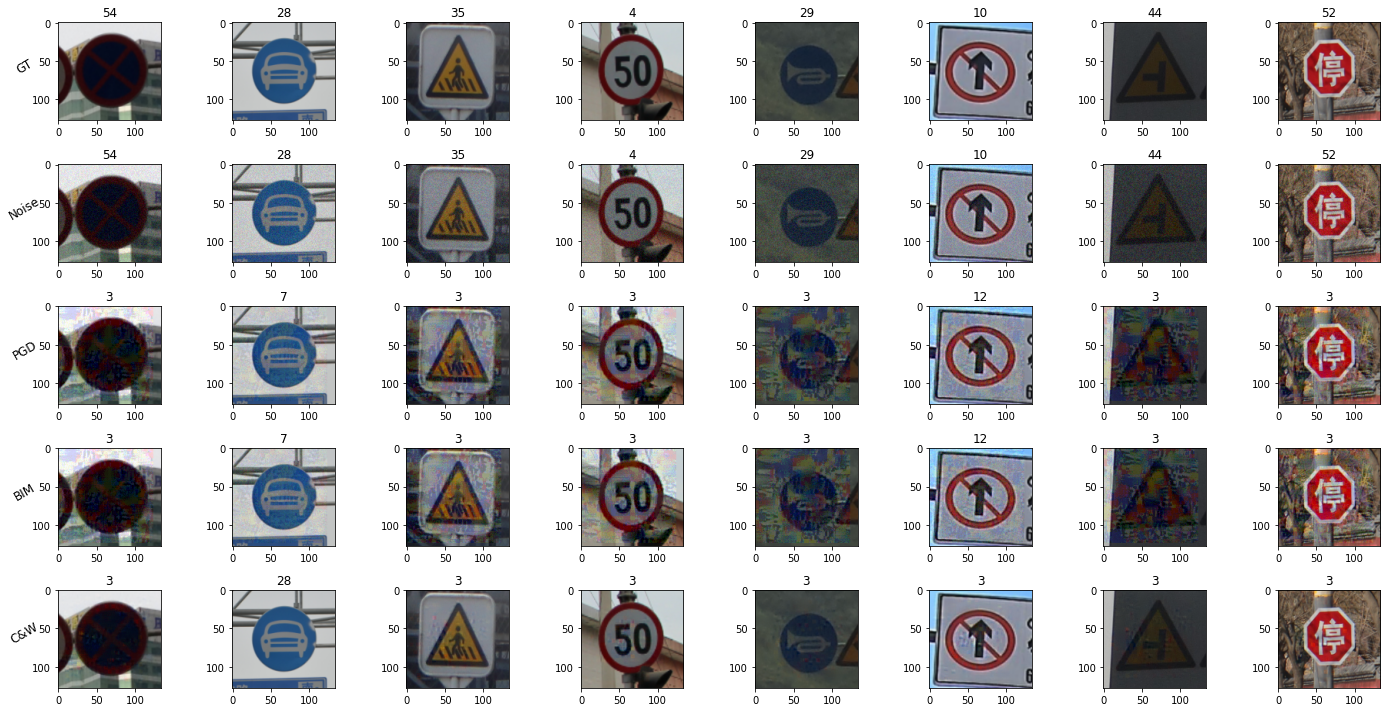

In [16]:
ROWS = 5
COLS = 8
fig, axes = plt.subplots(ROWS, COLS, figsize=(20, 10))

row_labels = ['GT', 'Noise', 'PGD', 'BIM', 'C&W']

for k in range(COLS):
    axes[0,k].imshow(valid_X[k])
    axes[1,k].imshow(valid_X_uniform_noise[k].clip(0.0,1.0)) #.clip(0.0,1.0)
    axes[2,k].imshow(valid_X_pgd[k])
    axes[3,k].imshow(valid_X_bim[k])
    axes[4,k].imshow(valid_X_cw[k])
    
    axes[0,k].set_title(str(pred_base[k].argmax()))
    axes[1,k].set_title(str(pred_noise[k].argmax()))
    axes[2,k].set_title(str(pred_pgd[k].argmax()))
    axes[3,k].set_title(str(pred_bim[k].argmax()))
    axes[4,k].set_title(str(pred_cw[k].argmax()))
    
for ax, row in zip(axes[:,0], row_labels):
    ax.set_ylabel(row, rotation=30, size='large')

fig.tight_layout()
plt.show()

We can now save the data that will be used for the next mini project

In [17]:
np.savez('../data/Part_3.1.npz', train_X=train_X, valid_X=valid_X, train_Y=train_Y,
         valid_Y=valid_Y, pred_base=pred_base,
         valid_X_pgd=valid_X_pgd, pred_pgd=pred_pgd,
         valid_X_bim=valid_X_bim, pred_bim=pred_bim,
         valid_X_cw=valid_X_cw, pred_cw=pred_cw)